In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [2]:
# Installing required packages
plt.style.use("dark_background")
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8s8yddvt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8s8yddvt
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [3]:
# Constants definition
BASE_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
BASE_LEN = 89
END_LEN = 4
END_MASK_LEN = 9
IMG_SIZE = 512

In [4]:
# Function to load image data
def load_data(base_path):
    data = []
    for dir_ in os.listdir(base_path):
        dir_path = os.path.join(base_path, dir_)
        if os.path.isdir(dir_path):
            for filename in os.listdir(dir_path):
                img_path = os.path.join(dir_path, filename)
                data.append([dir_, img_path])
        else:
            print(f"[INFO] This is not a directory --> {dir_path}")
    return pd.DataFrame(data, columns=["dir_name", "image_path"])

In [5]:
# Load image data into DataFrame
df = load_data(BASE_PATH)

# Displaying DataFrame
print("DataFrame loaded successfully!")
print(df.head())

[INFO] This is not a directory --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
[INFO] This is not a directory --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
DataFrame loaded successfully!
                dir_name                                         image_path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
# Filtering image and mask paths
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

# Sorting image and mask paths
imgs = sorted(df_imgs["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_MASK_LEN]))

# Randomly selecting an index
idx = random.randint(0, len(imgs) - 1)

# Displaying a random pair of image and mask paths
print(imgs[idx], masks[idx])

# Creating a DataFrame with image, mask, and patient information
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                    "image_path": imgs,
                    "mask_path": masks})

# Displaying the DataFrame
print(dff.head())

# Function to check if a patient has a diagnosis based on the mask
def check_patient(mask_path):
    val = np.max(cv2.imread(mask_path))
    if val > 0:
        return 1
    return 0

# Applying the function to determine patient diagnosis
dff["diagnosis"] = dff["mask_path"].apply(lambda x: check_patient(x))

# Displaying the updated DataFrame
print(dff.head())


/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_21.tif /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_21_mask.tif
                 patient                                         image_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T... 

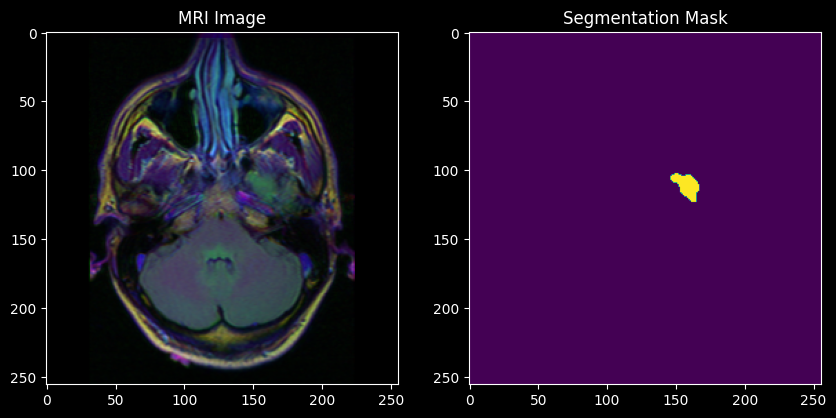

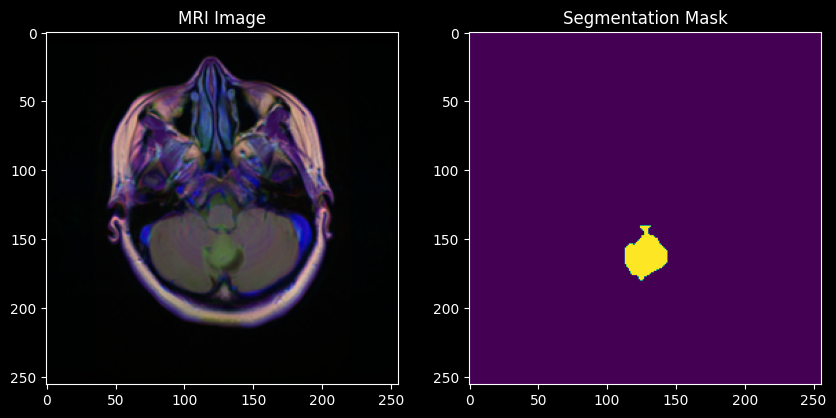

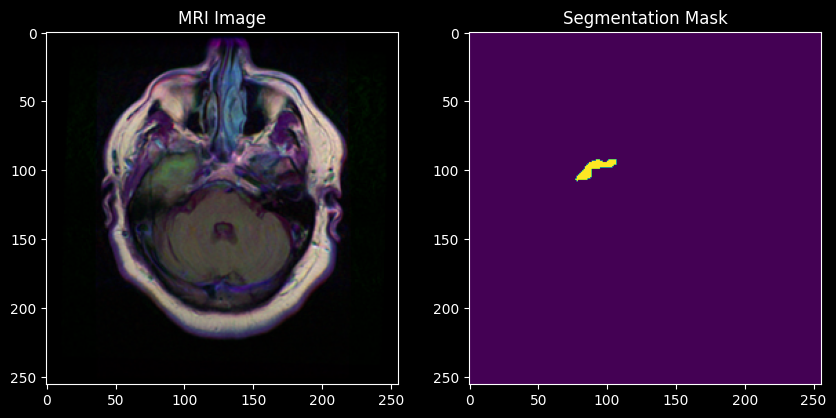

In [7]:
# Initializing empty lists to store test images and masks
img_test = []
mask_test = []

# Counter to keep track of the number of plots
plot_counter = 0

# Looping through the DataFrame to find patients with a diagnosis
for i in range(len(dff)):
    if dff.iloc[i, 3] == 1:  # Checking if the patient has a diagnosis
        # Loading the image and mask
        image = cv2.imread(dff.iloc[i, 1], 1)  # Reading image in color mode
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting image to RGB
        mask = cv2.imread(dff.iloc[i, 2], 0)  # Reading mask in grayscale mode

        # Displaying the image and mask
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        img_test = np.array(image)  # Converting image to numpy array
        mask_test = np.array(mask)  # Converting mask to numpy array
        ax[0].imshow(image, cmap='gray')  # Displaying image
        ax[0].set_title('MRI Image')  # Setting title for the image plot
        ax[1].imshow(mask)  # Displaying mask
        ax[1].set_title('Segmentation Mask')  # Setting title for the mask plot
        plt.show()  # Showing the plot
        plot_counter += 1  # Incrementing plot counter
        if plot_counter == 3:  # Breaking loop after plotting three examples
            break

In [8]:
def get_bounding_box(ground_truth_map):
    """
    Calculate bounding box coordinates from the ground truth segmentation mask with perturbation.
    
    Args:
    - ground_truth_map (numpy.ndarray): Ground truth segmentation mask
    
    Returns:
    - bbox (list): Bounding box coordinates [x_min, y_min, x_max, y_max]
    """
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(x_indices) == 0:
        return [0, 0, 0, 0]
    
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    
    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

class SAMDataset(Dataset):
    def __init__(self, df, processor):
        """
        SAMDataset constructor.
        
        Args:
        - df (DataFrame): DataFrame containing image and mask paths
        - processor (SamProcessor): SAM processor for preparing inputs
        
        """
        self.df = df
        self.processor = processor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        ground_truth_mask = np.array(mask)
        prompt = get_bounding_box(ground_truth_mask)
        
        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

2024-03-11 21:29:55.926885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 21:29:55.926981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 21:29:56.077870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [9]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train, validation, and test sets
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

# Displaying the sizes of train, validation, and test sets
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

# Creating datasets for training, validation, and testing
train_dataset = SAMDataset(train_df, processor)
val_dataset = SAMDataset(val_df, processor)
test_dataset = SAMDataset(test_df, processor)

# Displaying an example from the training dataset
example = train_dataset[0]
for k, v in example.items():
    print(k, v.shape)

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [10]:
from torch.utils.data import DataLoader

# Define batch size and learning rate
batch_size = 4
lr = 1e-4

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# Display an example from the training dataset
example = train_dataset[0]
for k, v in example.items():
    print(k, v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [11]:
from transformers import SamModel

# Load pre-trained SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Ensure that gradients are only computed for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [12]:
!pip install -q monai
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Define number of epochs and move the model to the appropriate device
num_epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

# Training loop
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_loader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Print epoch information
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 778/778 [16:18<00:00,  1.26s/it]


EPOCH: 0
Mean loss: -17199.363913576522


100%|██████████| 778/778 [15:54<00:00,  1.23s/it]


EPOCH: 1
Mean loss: -75876.85270022358


100%|██████████| 778/778 [15:53<00:00,  1.23s/it]

EPOCH: 2
Mean loss: -195789.694071887


In [13]:
import os
import torch
from transformers import SamModel, SamConfig, SamProcessor

# Define paths for saving and loading checkpoints
path = "files/"
if not os.path.exists(path):
    os.makedirs(path)
checkpoints_path = "files/model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), checkpoints_path)

# Load model configuration and processor
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)

# Update the model by loading the weights from the saved file
my_mito_model.load_state_dict(torch.load(checkpoints_path))

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

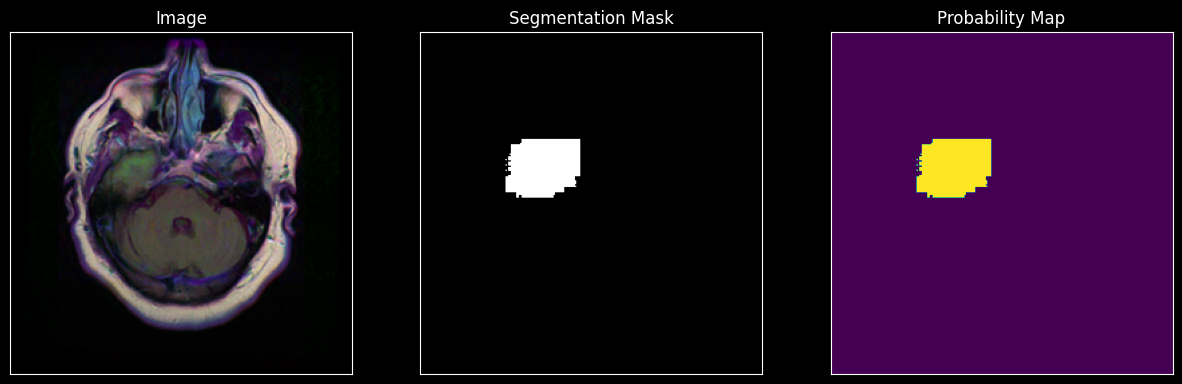

In [14]:
# Get bounding box from the test mask
prompt = get_bounding_box(mask_test)

# Prepare inputs for the model
inputs = processor(img_test, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Set the model to evaluation mode
model.eval()

# Compute predictions
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Apply sigmoid to the predicted segmentation probabilities
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# Convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

# Display segmentation results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
axes[0].imshow(np.array(img_test), cmap='gray')
axes[0].set_title("Image")

# Plot the segmentation mask
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Segmentation Mask")

# Plot the probability map
axes[2].imshow(medsam_seg_prob)
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images
plt.show()

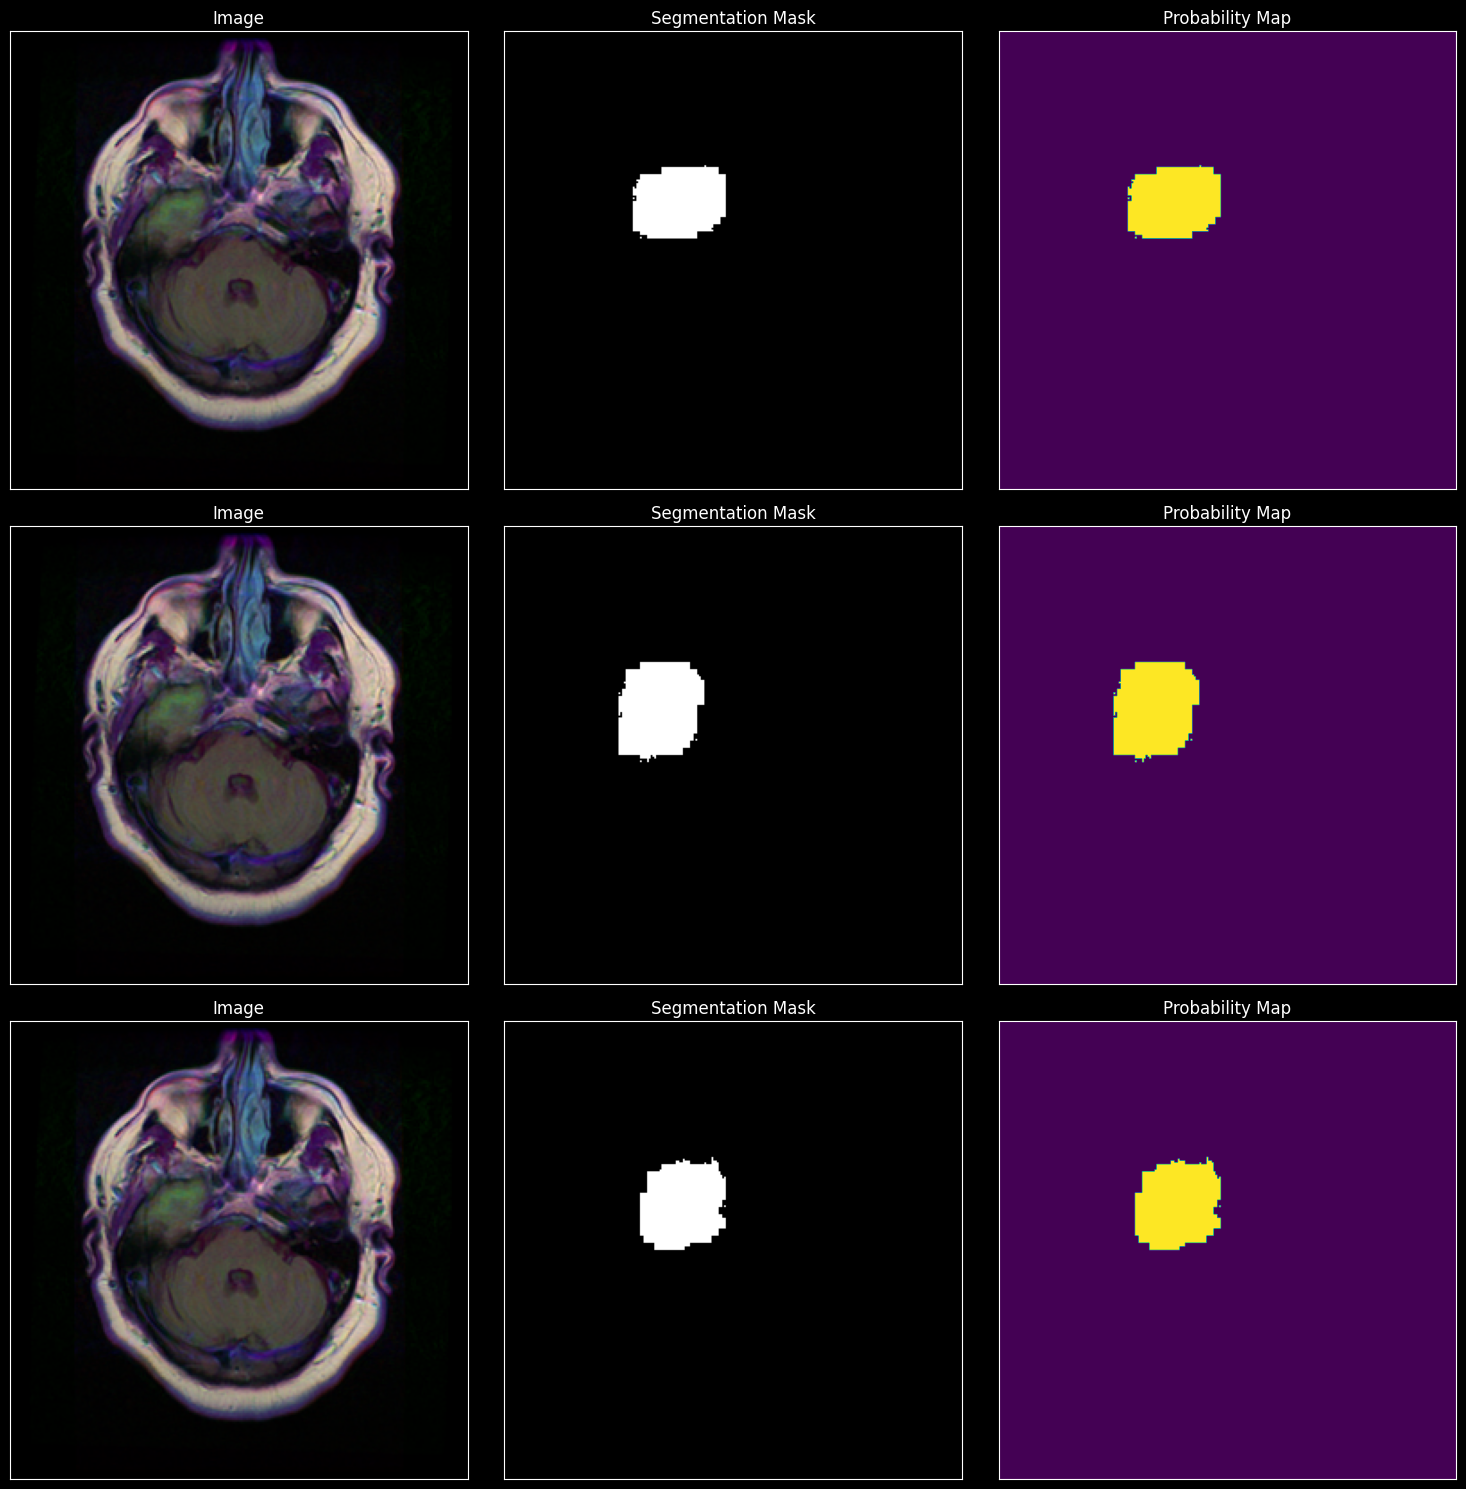

In [15]:
# Get bounding box from the test mask
prompt = get_bounding_box(mask_test)

# Prepare inputs for the model
inputs = processor(img_test, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Set the model to evaluation mode
model.eval()

# Compute predictions
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Apply sigmoid to the predicted segmentation probabilities
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# Convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

# Display segmentation results for multiple samples
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

for i in range(num_samples):
    # Get bounding box from the test mask
    prompt = get_bounding_box(mask_test)

    # Prepare inputs for the model
    inputs = processor(img_test, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Compute predictions
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # Apply sigmoid to the predicted segmentation probabilities
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    # Convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    # Plot the images
    axes[i, 0].imshow(np.array(img_test), cmap='gray')
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(medsam_seg, cmap='gray')
    axes[i, 1].set_title("Segmentation Mask")

    axes[i, 2].imshow(medsam_seg_prob)
    axes[i, 2].set_title("Probability Map")

    # Hide axis ticks and labels
    for ax in axes[i]:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# Display the images
plt.tight_layout()
plt.show()

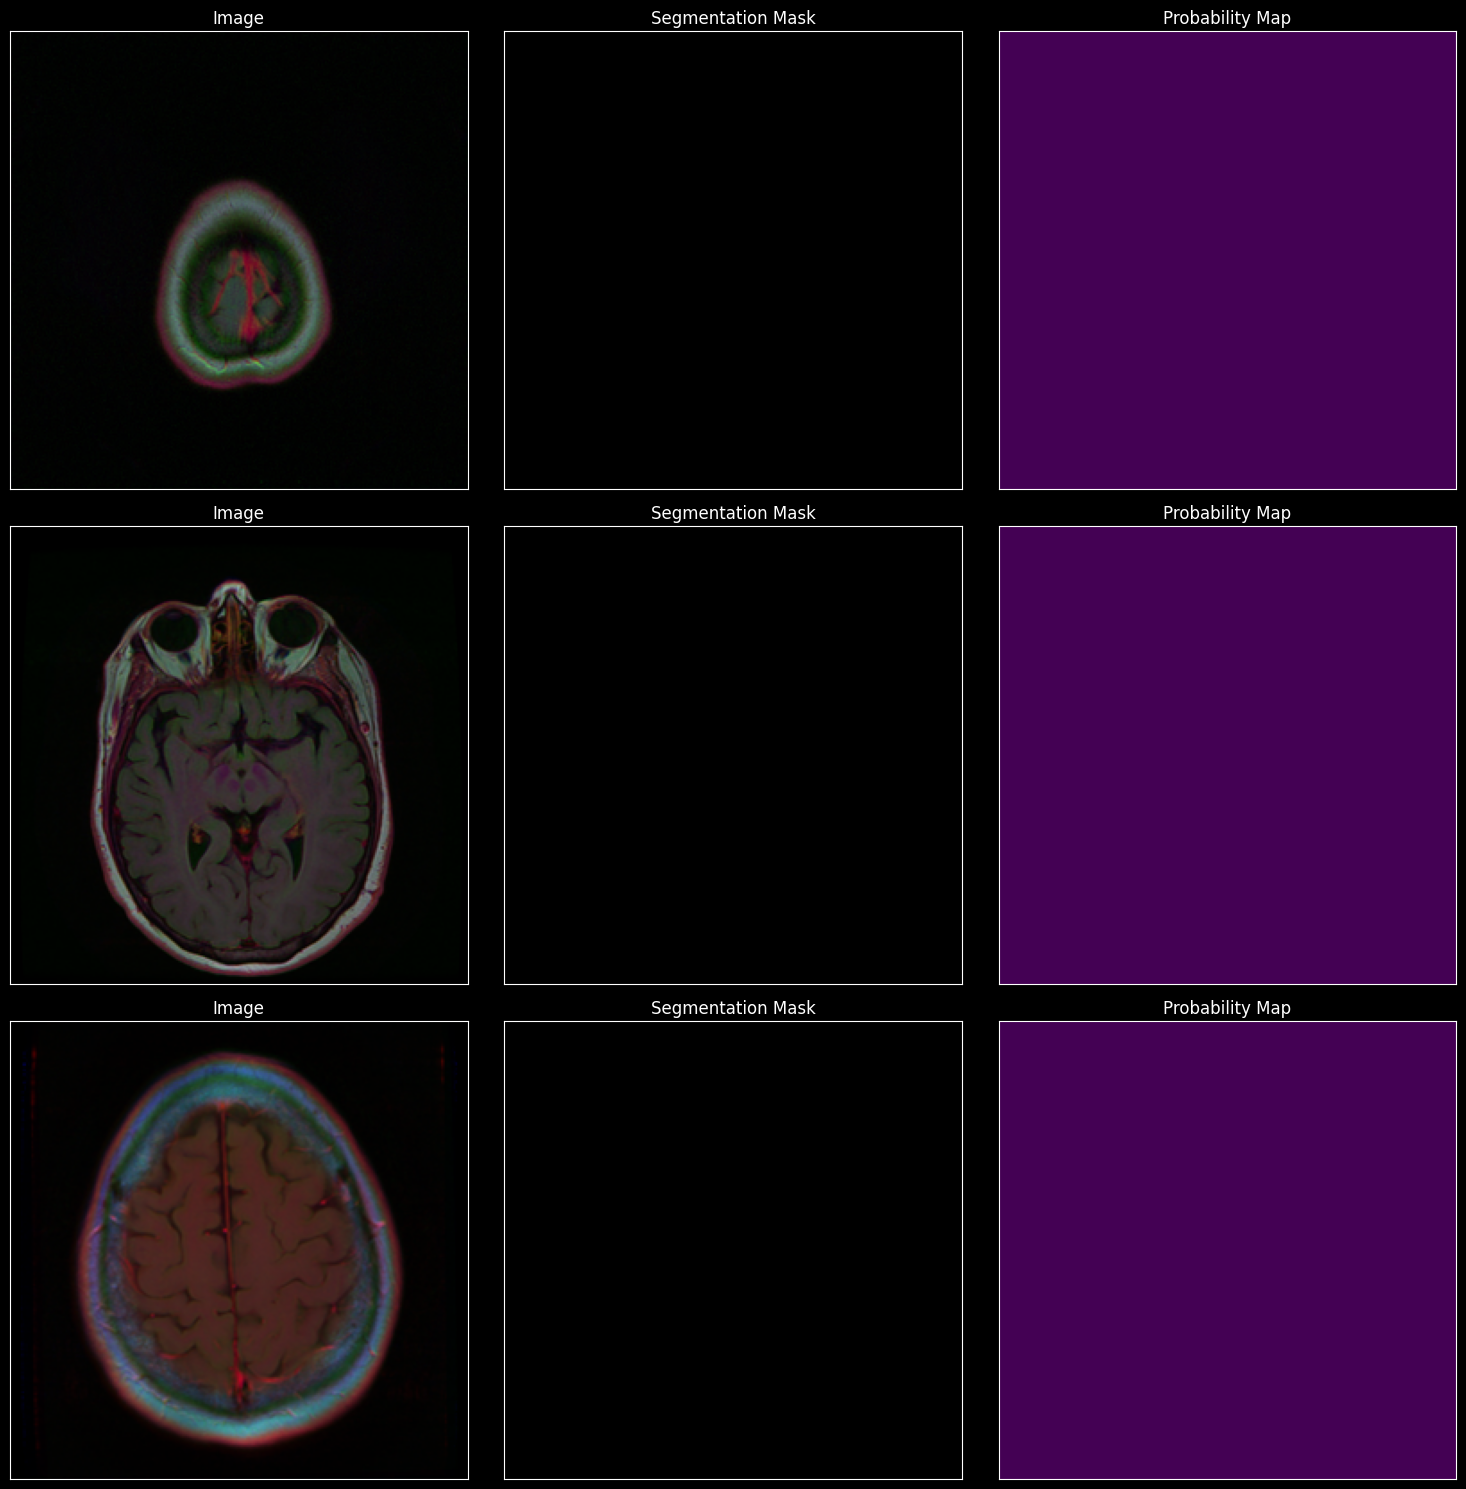

In [16]:
# Display segmentation results for three different images
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

for i in range(num_samples):
    # Select three different images from the dataset
    idx = random.randint(0, len(imgs)-1)
    img_path = imgs[idx]
    mask_path = masks[idx]
    
    # Load the selected image and mask
    img_test = cv2.imread(img_path)
    mask_test = cv2.imread(mask_path, 0)
    
    # Get bounding box from the test mask
    prompt = get_bounding_box(mask_test)
    
    # Prepare inputs for the model
    inputs = processor(img_test, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Compute predictions
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # Apply sigmoid to the predicted segmentation probabilities
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    # Convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    # Plot the images
    axes[i, 0].imshow(np.array(img_test), cmap='gray')
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(medsam_seg, cmap='gray')
    axes[i, 1].set_title("Segmentation Mask")

    axes[i, 2].imshow(medsam_seg_prob)
    axes[i, 2].set_title("Probability Map")

    # Hide axis ticks and labels
    for ax in axes[i]:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# Display the images
plt.tight_layout()
plt.show()